In [1]:
import os
import zipfile

import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score, adjusted_rand_score

# Step 0: Load the data

In [2]:
path_data = "./data"

In [3]:
bulk_pancreas = pd.read_csv(
    os.path.join(path_data, "train_data", "pancreas_bulk_train.csv")
).set_index("level_0")

In [4]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453


In [5]:
sc_pancreas = pd.read_csv(
    os.path.join(path_data, "train_data", "pancreas_sc_train.csv")
).set_index("Unnamed: 0")

In [6]:
assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of cells in the train dataset 978


In [7]:
sc_pancreas_test = pd.read_csv(
    os.path.join(path_data, "test_data", "pancreas_sc_test.csv")
).set_index("Unnamed: 0")

In [8]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [9]:
sc_pancreas_metadata = pd.read_csv(
    os.path.join(path_data, "train_data", "pancreas_sc_metadata_train.csv")
).set_index("Source Name")

In [10]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(
        f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}"
    )

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [11]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease == dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [12]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [13]:
sc_pancreas_metadata_test = pd.read_csv(
    os.path.join(path_data, "test_data", "pancreas_sc_metadata_test_wocelltype.csv")
).set_index("Source Name")

In [14]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(
        f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}"
    )

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [15]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease == dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


__What do we have now?__

- bulk_pancreas: pd dataframe, train data. Bulk expression counts.
- sc_pancreas: pd dataframe, train data. Single-cell expression counts.
- sc_pancreas_test: pd dataframe, test data. Single-cell expression counts.
- sc_pancreas_metadata: pd dataframe, train data.
- sc_pancreas_metadata_test: pd dataframe, test data.
    - sc_pancreas_metadata.Disease: either 'type II diabetes mellitus' or 'normal'
    - sc_pancreas_metadata.Celltype: string of the cell type.

In [16]:
sc_pancreas_all = pd.concat([sc_pancreas, sc_pancreas_test], axis=1)
sc_pancreas_metadata_all = pd.concat(
    [sc_pancreas_metadata, sc_pancreas_metadata_test], axis=0
)
sc_pancreas_metadata_all["Type"] = sc_pancreas_metadata_all.apply(
    lambda x: "train" if x["Sample"] in bulk_pancreas.columns else "test", axis=1
)

In [17]:
sc_pancreas_all

,patient1_A10,patient1_A12,patient1_A13,patient1_A15,patient1_A17,patient1_A18,patient1_A19,patient1_A20,patient1_A23,patient1_A24,...,patient6_P18,patient6_P19,patient6_P2,patient6_P20,patient6_P21,patient6_P22,patient6_P23,patient6_P4,patient6_P7,patient6_P9
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
SGIP1,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZIN2,0.0,0.0,110.0,0.0,1.0,0.0,0.0,0.0,0.0,192.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,6.0
CLIC4,127.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,30.0,0.0,...,8.0,0.0,3.0,7.0,33.0,0.0,0.0,0.0,16.0,0.0
AGBL4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
NECAP2,140.0,0.0,0.0,171.0,87.0,32.0,0.0,0.0,0.0,39.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIR2DL5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
sc_pancreas_metadata_all

,Sample,Disease,Celltype,Type
Source Name,,,,
patient1_A10,patient1,type II diabetes mellitus,acinar cell,train
patient1_A12,patient1,type II diabetes mellitus,alpha cell,train
patient1_A13,patient1,type II diabetes mellitus,gamma cell,train
patient1_A15,patient1,type II diabetes mellitus,gamma cell,train
patient1_A17,patient1,type II diabetes mellitus,gamma cell,train
...,...,...,...,...
patient6_P22,patient6,type II diabetes mellitus,NaN,test
patient6_P23,patient6,type II diabetes mellitus,NaN,test
patient6_P4,patient6,type II diabetes mellitus,NaN,test


# Step 1: Perform the imputation

In [19]:
adata = sc.AnnData(sc_pancreas_all.T)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
X_magic = sce.pp.magic(
    sc_pancreas_all.T, name_list="all_genes", knn=5, n_jobs=-1, copy=True
).T

/var/folders/xf/5_5_k9g1053gtrz3jbz8c2hc0000gn/T/ipykernel_68960/2881858571.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(sc_pancreas_all.T)
/Users/tobi/Documents/MLG_Project2/venv/lib/python3.9/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Running MAGIC with `solver='exact'` on 25453-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/Users/tobi/Documents/MLG_Project2/venv/lib/python3.9/site-packages/scanpy/external/pp/_magic.py:194: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_magic.raw = adata


In [20]:
rawbulk = bulk_pancreas.copy()

for s in sc_pancreas_metadata_all.Sample.unique():
    f = sc_pancreas_metadata_all.Sample == s
    rawbulk[s] = sc_pancreas_all.loc[:, f].sum(axis=1)

np.log(bulk_pancreas + 1).corrwith(np.log(rawbulk + 1)).mean()

0.9411428457639999

In [21]:
magicbulk = bulk_pancreas.copy()

for s in sc_pancreas_metadata_all.Sample.unique():
    f = sc_pancreas_metadata_all.Sample == s
    magicbulk[s] = X_magic.loc[:, f].sum(axis=1)

np.log(bulk_pancreas + 1).corrwith(np.log(magicbulk + 1)).mean()

0.9556357929309236

Note the substantial increase in correlation between the two methods.

# Step 2: Perform clustering

In [22]:
# Pre-Processing
adata = sc.AnnData(sc_pancreas_all.T, obs=sc_pancreas_metadata_all)
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sce.pp.harmony_integrate(adata, "Sample", adjusted_basis="X_pca", max_iter_harmony=20)

/var/folders/xf/5_5_k9g1053gtrz3jbz8c2hc0000gn/T/ipykernel_68960/3173167530.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(sc_pancreas_all.T, obs=sc_pancreas_metadata_all)
2022-05-01 15:13:15,969 - harmonypy - INFO - Iteration 1 of 20
2022-05-01 15:13:16,341 - harmonypy - INFO - Iteration 2 of 20
2022-05-01 15:13:16,667 - harmonypy - INFO - Iteration 3 of 20
2022-05-01 15:13:16,937 - harmonypy - INFO - Iteration 4 of 20
2022-05-01 15:13:17,201 - harmonypy - INFO - Iteration 5 of 20
2022-05-01 15:13:17,354 - harmonypy - INFO - Iteration 6 of 20
2022-05-01 15:13:17,675 - harmonypy - INFO - Iteration 7 of 20
2022-05-01 15:13:17,948 - harmonypy - INFO - Iteration 8 of 20
2022-05-01 15:13:18,125 - harmonypy - INFO - Iteration 9 of 20
2022-05-01 15:13:18,241 - harmon

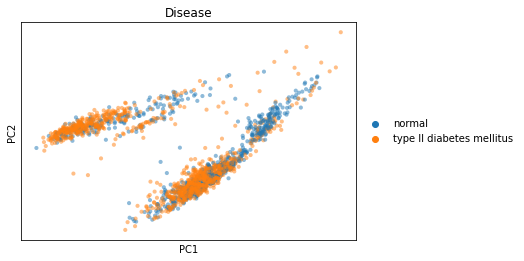

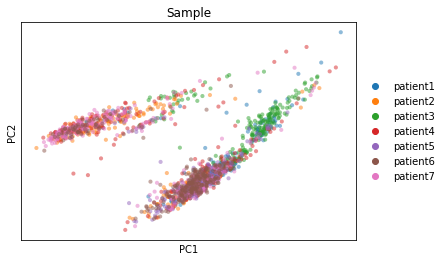

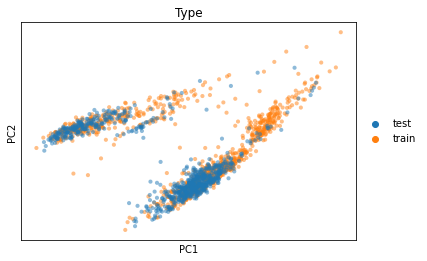

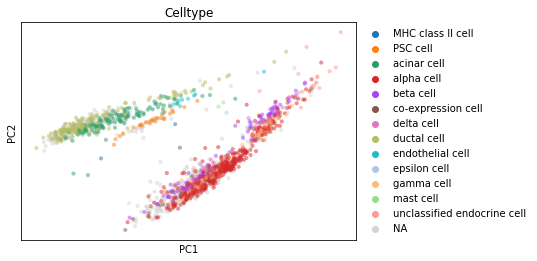

In [23]:
for i, colorby in enumerate(["Disease", "Sample", "Type", "Celltype"]):
    sc.pl.pca(adata, color=colorby, alpha=0.5)

In [24]:
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata, n_components=50)
sc.tl.leiden(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [25]:
# Cluster Merging

merge_dict = dict()
for i in adata.obs.leiden.unique():
    try:
        merge_dict[i] = (
            adata.obs[adata.obs.leiden == i].Celltype.value_counts().index[0]
        )
    except:
        merge_dict[i] = "Unknown"

adata.obs["leiden_merged"] = adata.obs["leiden"].map(merge_dict).astype("category")

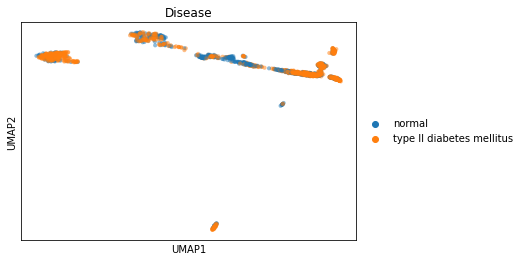

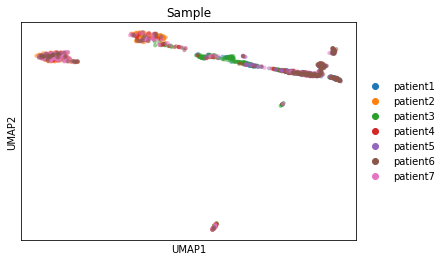

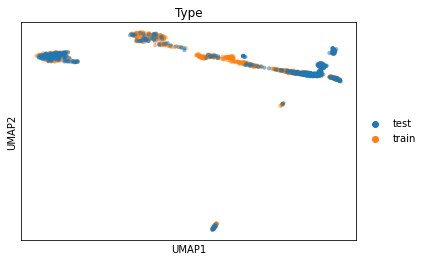

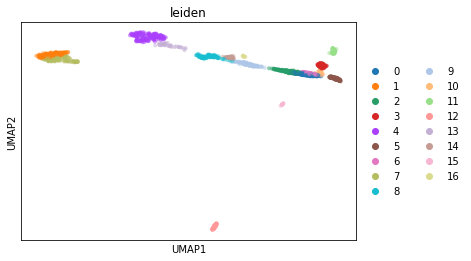

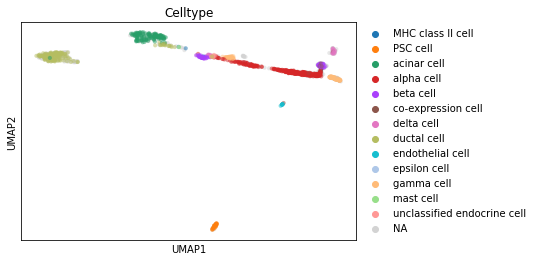

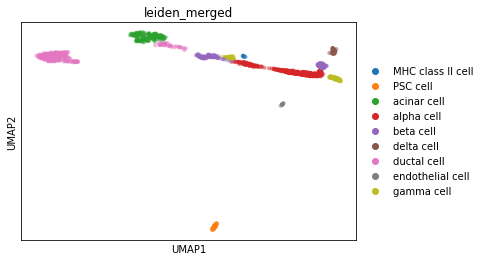

In [26]:
# for i, colorby in enumerate(["Disease", "Celltype", "Sample", "Type", "leiden", "leiden_merged"]):
for i, colorby in enumerate(
    ["Disease", "Sample", "Type", "leiden", "Celltype", "leiden_merged"]
):
    sc.pl.umap(adata, color=colorby, alpha=0.5)

In [27]:
ssc = silhouette_score(
    adata.obsm["X_umap"][adata.obs.Type == "train", :50],
    adata.obs["leiden_merged"][adata.obs.Type == "train"],
)
ssc

0.4908299

In [28]:
ari = adjusted_rand_score(
    adata.obs.Celltype.cat.codes[adata.obs.Type == "train"],
    adata.obs.leiden_merged.cat.codes[adata.obs.Type == "train"],
)
ari

0.8922777901765407

In [29]:
v = v_measure_score(
    adata.obs.Celltype.cat.codes[adata.obs.Type == "train"],
    adata.obs.leiden_merged.cat.codes[adata.obs.Type == "train"],
)
v

0.8769357048630969

In [30]:
(ssc + ari + v) / 3

0.753347803282637

# Step 3: Predict on the test data

In [31]:
bulkified = magicbulk.loc[sc_pancreas_test.index, ["patient5", "patient6", "patient7"]]

bulkified["index"] = bulkified.index
bulkified = bulkified[["index", "patient5", "patient6", "patient7"]]

In [32]:
cluster_labels = pd.DataFrame(
    index=sc_pancreas_test.columns,
    columns=["cluster"],
)

cluster_labels["cluster"] = (
    adata.obs.leiden_merged.cat.codes[sc_pancreas_test.columns] + 1
)

cluster_labels["index"] = cluster_labels.index
cluster_labels = cluster_labels[["index", "cluster"]]

In [48]:
PCA = pd.DataFrame(
    data=adata.obsm["X_umap"][adata.obs.Type == "test", :50],
    index=sc_pancreas_test.columns,
    columns=[f"PC{i+1}" for i in range(50)],
)

PCA["index"] = PCA.index
PCA = PCA[["index"] + [f"PC{i+1}" for i in range(50)]]

# Step 4: Save the required files

In [49]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [50]:
results_path = "./results"
archive_name = "Scheithauer_Tobias_Project2.zip"  # TODO

In [51]:
assert all(bulkified.columns == ["index", "patient5", "patient6", "patient7"])

In [52]:
assert all(bulkified["index"] == sc_pancreas_test.index)

In [53]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [54]:
assert all(cluster_labels.columns == ["index", "cluster"])

In [55]:
assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [56]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [57]:
assert all(PCA.columns == ["index"] + ["PC" + str(i + 1) for i in range(50)])

In [58]:
assert all(PCA["index"] == sc_pancreas_test.columns)

In [59]:
with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
    with zf.open(f"imputed_bulkified.csv", "w") as buffer:
        bulkified.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    with zf.open(f"PCA.csv", "w") as buffer:
        PCA.to_csv(buffer)
    zf.close()

In [60]:
archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
assert all(
    [
        i in archive.namelist()
        for i in [
            "imputed_bulkified.csv",
            "cluster_membership.csv",
            "PCA.csv",
        ]
    ]
)